In [1]:
import os,sys
import numpy as np
import scipy.stats as st
from BA import BA
import math
import random as rand
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import scipy.stats as st
from matplotlib import rcParams
from matplotlib import gridspec
from sklearn.feature_selection import f_regression, mutual_info_regression

In [2]:
def sample_X(true_cdf):
    xi = rand.uniform(0,1.0)
    
    i = np.argwhere(true_cdf>xi)[0][0]
    
    return i

In [3]:
def next_jump(total_propensity):
    xi = rand.uniform(1e-6,1.0)
    dt = -math.log(xi)/total_propensity
    
    return dt

In [4]:
def next_jump_and_event_type(on,off,m_p,m_d):
    total = on + off + m_p + m_d #+ g_p + g_d
    
    """
    tol = 1.0
    
    if g_d>1000.0:
        tol = abs((g_p-g_d)/g_d)
        
    if tol<1e-3:
        g_p = 0.0
        g_d = 0.0
   
    total = on + off + m_p + m_d + g_p + g_d
    """
    
    xi = rand.uniform(0,1.0)
    
    if xi<m_p/total:
        event = 'm_p'
    elif xi>=m_p/total and xi<(m_p+m_d)/total:
        event = 'm_d'
    elif xi>=(m_p+m_d)/total and xi<(m_p+m_d+on)/total:
        event = 'on'
    else:
        event = 'off'
        
    xi = rand.uniform(1e-8,1.0)
        
    dt = -math.log(xi)/total
        
    return event, dt

In [5]:
data_directory = '/Users/sns9/Research/Translation/Fluctuation/'
os.chdir(data_directory)

In [6]:
true_pX = np.array([1.97544481e-01,1.55334094e-01,8.72423287e-02,8.89069841e-02,5.95158979e-02,8.41338592e-02,2.72777107e-02,1.00156427e-01,2.62008568e-02,6.88904865e-09,1.73687353e-01])
#true_pX = np.array([3.83054761e-01,1.52372266e-14,1.73337948e-04,2.38679663e-01,9.75073605e-03,2.14571753e-06,1.19640527e-10,7.93108858e-14,3.71098738e-14,5.98113341e-10,3.68339356e-01])

#true_pX = np.array([7.67471479e-02,7.07115889e-02,5.96254097e-02,5.06332960e-02,4.45903953e-02,4.03738471e-02,3.72052648e-02,
#                    3.47265258e-02,3.27371321e-02,3.10596303e-02,2.96573937e-02,2.84588995e-02,2.73639770e-02,2.65203478e-02,
#                    2.55496092e-02,2.50607510e-02,2.40085658e-02,2.39612136e-02,2.27913684e-02,2.26201766e-02,2.30338585e-02,
#                    1.88383021e-02,2.77594588e-02,9.47090812e-03,3.77477514e-02,0.00000000e+00,3.95128195e-02,9.83121761e-05,
#                    4.32814401e-02,0.00000000e+00,0.00000000e+00,6.58546090e-02])

In [7]:
# leaky expression coefficient 
l = 0.01
X = np.linspace(0,1.0,11)
sX = np.linspace(0,1.0,11)
print(X)
pr_array = np.zeros(shape=(X.shape[0],3))

true_cdf = np.zeros(shape=(true_pX.shape[0]))

for i in range(0,X.shape[0]):
    true_cdf[i] = np.sum(true_pX) - np.sum(true_pX[i+1:])
    
print(true_cdf)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.19754448 0.35287857 0.4401209  0.52902789 0.58854379 0.67267764
 0.69995536 0.80011178 0.82631264 0.82631265 1.        ]


2000.0


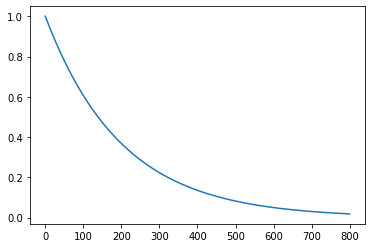

In [8]:
# Frequency factor for k_on and k_off
alpha = 1.0

# Transcription parameters
k_m = 0.5
k_dm = 0.5

# Translation parameters
T = 100
k_dg = k_dm/T

# Kernel window size
kernel_window_size = 4.0

# Fluctuation period
Tf = 10.0/k_dg

print(Tf)

kernel_window_time = kernel_window_size/k_dg

kernel_points = int(kernel_window_size*k_dm/k_dg)
kernel_times = np.linspace(0,kernel_window_time,kernel_points+1)
kernel = np.zeros(shape=(kernel_points+1,))

for j in range(0,kernel_times.shape[0]):
    kernel[j] = math.exp(-k_dg*kernel_times[j])
    
plt.plot(kernel_times,kernel)

In [9]:
# Create transcript bins
k_low = (k_m/k_dm)*l
k_up = k_m/k_dm

m_min = 0
m_max = st.poisson.ppf(0.99,1.0)

m_pdfs = np.zeros(shape=(X.shape[0],int(m_max+1)))

g_min = st.gamma.ppf(0.01,k_low,0,1)
g_max = st.gamma.ppf(0.99,k_up,0,1)
print(g_min,g_max)

bin_size = 50

g_bins = list(10**np.linspace(math.log10(0.1),math.log10(g_max+1),bin_size))
g_bins.insert(0,-1)
g_bins = np.array(g_bins)
g_pdfs = np.zeros(shape=(X.shape[0],bin_size))
expressions = np.zeros(shape=(X.shape[0]+1,bin_size))

In [10]:
# Number of samples
#n_samples = 1000000
#n_samples = int(10000*Tf/t_sample)+1

# Repeats
reps = 10

# Sampling interval
t_sample = 1.0/k_dm

n_samples = int(100*Tf/t_sample)

joint_samples = np.zeros(shape=(n_samples,3))
times = np.zeros(shape=(n_samples,))

print('Total X samples: ',(n_samples*t_sample)/Tf,n_samples)

Total X samples:  100.0 100000


In [11]:
ii = sample_X(true_cdf)
tX = X[ii]

current_time = 0.0
event_counter = 0
last_sample_event = 0

# Operator state 
O_on = 0
O_off = 1

# Transcription on or off    
k_on = alpha*((1-l)*tX + l)
k_off = alpha*(1 - tX)*(1 - l)

# Initial transcript count
m_g = int((k_m/k_dm)*k_on/(k_on + k_off))

m_g_samples = np.zeros(shape=(n_samples,))
m_g_samples[0] = m_g

g_int = 0.0

current_time = 0
next_sample_time = t_sample
samples = 1
next_switch_time = Tf
X_samples = [tX]

while samples<n_samples:
    # Transcription on or off    
    k_on = alpha*((1-l)*tX + l)
    k_off = alpha*(1 - tX)*(1 - l)

    # transcription propensities
    m_production = k_m*O_on
    m_degradation = k_dm*m_g

    event, dt = next_jump_and_event_type(k_on,k_off,m_production,m_degradation)

    current_time += dt
    event_counter += 1

    if current_time>next_sample_time:
        joint_samples[samples,0] = tX
        joint_samples[samples,1] = m_g
        joint_samples[samples,2] = O_on
        
        times[samples] = current_time

        next_sample_time += t_sample + (current_time - next_sample_time)

        samples += 1

        last_sample_event = event_counter
        
    if current_time>next_switch_time:
        ii = sample_X(true_cdf)
        tX = X[ii]
        
        X_samples.append(tX)

        next_switch_time += Tf + (current_time - next_sample_time)        

    if event=='m_p':
        m_g += 1
    elif event=='m_d':
        m_g += -1
    elif event=='off':
        O_on = 0
        O_off = 1
    elif event=='on':
        O_on = 1
        O_off = 0

g_samples = np.convolve(np.array(joint_samples[:,1]),np.array(kernel),'valid')

In [12]:
print(g_samples.shape)
print(len(X_samples))
g_times = times[(times.shape[0]-g_samples.shape[0]):]

joint_g = np.zeros(shape=(g_times.shape[0],2))
joint_g[:,1] = g_samples
joint_g[:,0] = joint_samples[(times.shape[0]-g_samples.shape[0]):,0]

(99600,)
141


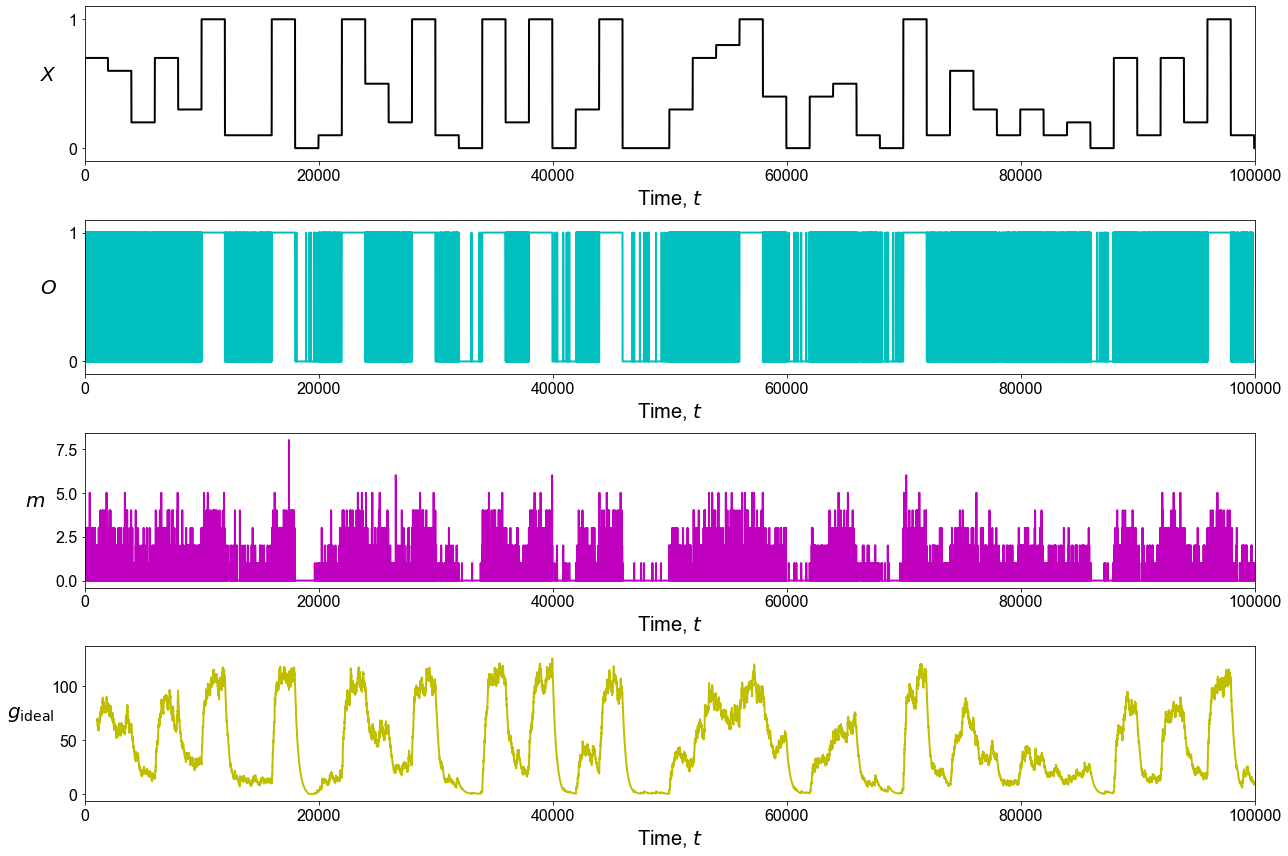

In [13]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

#fig, (ax1, ax2, ax3) = plt.figure(figsize=(5,3))

#fig, axs = plt.subplots(1,3,figsize=(20,3))

fig = plt.figure(figsize=(18,12))
gs = gridspec.GridSpec(4,1)#,width_ratios=[2,1,2])

axs = {}

axs[0] = plt.subplot(gs[0])
axs[0].plot(times,joint_samples[:,0],lw=2,color='black')
#axs[0].hlines(joint_samples[:-1,0],times[:-1],times[1:],lw=3,color='black')
axs[0].set_xlabel(r'Time, $t$',fontsize=20)
axs[0].set_ylabel(r'$X$',fontsize=20,rotation=0,labelpad=20)
#axs[0].set_xlim(0,max(kernel_times))
axs[0].set_xlim(0,100000)
axs[0].set_yticks([0,1])
axs[0].set_ylim(-0.1,1.1)
axs[0].tick_params(labelsize=16)

axs[1] = plt.subplot(gs[1])
axs[1].plot(times,joint_samples[:,2],lw=2,color='c')
axs[1].set_xlabel(r'Time, $t$',fontsize=20)
axs[1].set_ylabel(r'$O$',fontsize=20,rotation=0,labelpad=20)
#axs[0].set_xlim(0,max(kernel_times))
axs[1].set_xlim(0,100000)
axs[1].set_yticks([0,1])
axs[1].set_ylim(-0.1,1.1)
axs[1].tick_params(labelsize=16)

axs[2] = plt.subplot(gs[2])
axs[2].step(times,joint_samples[:,1],lw=2,color='m')
axs[2].set_xlabel(r'Time, $t$',fontsize=20)
axs[2].set_ylabel(r'$m$',fontsize=20,rotation=0,labelpad=20)
#axs[1].set_xlim(0,max(mg_times))
axs[2].set_xlim(0,100000)
#axs[2].set_ylim(-0.5,4)
axs[2].tick_params(labelsize=16)

axs[3] = plt.subplot(gs[3])
axs[3].plot(g_times,g_samples,lw=2,color='y')
axs[3].set_xlabel(r'Time, $t$',fontsize=20)
axs[3].set_ylabel(r'$g_{\mathrm{ideal}}$',fontsize=20,rotation=0,labelpad=20)
#axs[2].set_xlim(0,max(mg_times[:-(len(kernel)-1)]))
axs[3].set_xlim(0,100000)
#axs[2].set_ylim(950,1100)
axs[3].tick_params(labelsize=16)

plt.tight_layout()
plt.savefig('stochastic_protocol.png',dpi=300)

In [ ]:
total_g_samples = {}

for iX in list(X):
    total_g_samples[str(iX)] = []
    
for i in range(0,g_times.shape[0]):
    total_g_samples[str(joint_g[i,0])].append(joint_g[i,1])
    
gmax, gmin = max(joint_g[:,1]), min(joint_g[:,0])

bin_size = min(25,int(gmax - gmin))
g_bins = np.linspace(gmin,gmax,bin_size+1)
g_pdfs = np.zeros(shape=(X.shape[0],bin_size))

for i in range(0,X.shape[0]):
    if i!=9:
        hist, be = np.histogram(total_g_samples[str(X[i])],g_bins)
        g_pdfs[i,:] = hist#/np.sum(hist)
    
#bao = BA()
#bao.set_response(g_pdfs)
#c_g, e, p = bao.get_CC()
#print(c_g)
g_pdfs *= 1.0/np.sum(np.sum(g_pdfs))
print(np.sum(np.sum(g_pdfs)))

In [ ]:
print(np.sum(g_pdfs,axis=1))

In [ ]:
h, b = np.histogram(joint_samples[:,0],bins=X.shape[0])
print(h)
h = h/np.sum(h)

plt.plot(X,h,alpha=0.5,color='r')
plt.plot(X,true_pX,color='g')

In [ ]:
pX = np.sum(g_pdfs,axis=1)
pg = np.sum(g_pdfs,axis=0)

mi = 0.0

for i in range(0,g_pdfs.shape[0]):
    for j in range(0,g_pdfs.shape[1]):
        if pX[i]>0.0 and pg[j]>0.0 and g_pdfs[i,j]>0.0:
            mi += g_pdfs[i,j]*math.log(g_pdfs[i,j]/(pX[i]*pg[j]))
            
mi *= 1.0/math.log(2.0)
print(mi)

casename = 'expressions'+str(k_g).replace('.','_')+'-'+str(k_dg).replace('.','_')+'.csv'

expressions[1:,:] = g_pdfs

lg_bins = list(np.log10(g_bins))
g_head = np.array([0.5*(lg_bins[i]+lg_bins[i+1]) for i in range(0,len(lg_bins)-1)])

expressions[0,:] = 10**g_head

np.savetxt(casename,expressions,delimiter=',')

In [ ]:
filename = 'Ifluc'+str(int(T))+'.csv'

try:
    ff = open(filename,'a')
except OSError:
    ff = open(filename,'w')
    print('Tf,rTf,T,I',file=ff)
    ff.close()
    
print(str(Tf)+','+str(Tf*k_dg)+','+str(k_dm/k_dg)+','+str(mi),file=open(filename,'a'))

In [ ]:
r_params = np.zeros(shape=(X.shape[0],2))
X[-1] = 0.99

for i in range(0,X.shape[0]):
    k_on = alpha*((1-l)*X[i] + l)
    k_off = alpha*(1 - X[i])*(1 - l)
    
    m = (k_m/k_dm)*k_on/(k_on + k_off)
    
    b = 1 + (k_dm*k_off*m)/(k_on*(k_on+k_off+k_dm)) 
    
    beta = b - 1
    
    if beta>0.0:
        r_params[i,0] = m/beta
        r_params[i,1] = (b - 1.0)/b
    else:
        r_params[i,0] = m
        r_params[i,1] = 0.0
    
print(r_params)

t = 1000

# create bins
if r_params[0,1]>0.0:
    g_min = st.nbinom.ppf(0.01,r_params[0,0]*t,1-r_params[0,1])

if r_params[-1,1]>0.0:
    g_max = st.nbinom.ppf(0.99,r_params[-1,0]*t,1-r_params[-1,1])
    
bin_size = int(min(200,g_max - g_min + 1))
#bin_size = g_max - g_min + 1
print(bin_size)

g_bin_edges = np.linspace(g_min,g_max+1,bin_size+1)
g_locs_i = g_bin_edges.astype(int)
g_pdfs = np.zeros(shape=(r_params.shape[0],g_locs_i.shape[0]))

for i in range(0,r_params.shape[0]):
    if r_params[i,1]>0.0:
        p = r_params[i,1]
        r = r_params[i,0]*t

        #g_samples = st.nbinom.rvs(r,1-p,0,n_samples)
        #g_cdf = st.nbinom.cdf(g_bins,r,1-p)

        l_cdf = st.nbinom.cdf(g_locs_i,r,1-p,0)
        l_pdf = l_cdf
        l_pdf[1:] = l_pdf[1:] - l_pdf[:-1]

    g_pdfs[i,:] = l_pdf/np.sum(l_pdf)
    
bao = BA()
bao.set_response(g_pdfs)
c_g, e, p = bao.get_CC()

print(c_g,p)

In [ ]:
d10 = pd.read_csv('Ifluc10.csv').to_numpy()
d100 = pd.read_csv('Ifluc100.csv').to_numpy()

In [ ]:
fig = plt.figure(figsize=(7,5))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

plt.plot(d10[:,0],d10[:,3],lw=1.0,marker='o',ms=7,label=r'$T = 10$',color='black')
plt.plot(d100[:,0],d100[:,3],lw=1.0,marker='^',ms=8,label=r'$T = 100$',color='blue')

plt.plot([3,d10[-1,0]],[1.18,1.18],lw=3.0,alpha=0.25,color='black')
plt.plot([3,d100[-1,0]],[2.28,2.28],lw=3.0,alpha=0.25,color='blue')

plt.plot([20,20],[-0.5,0.1],lw=3.0,alpha=0.25,color='black')
plt.plot([200,200],[-0.5,0.25],lw=3.0,alpha=0.25,color='blue')

plt.xscale('log')
plt.ylim(-0.1,2.5)
plt.xlim(3,50000)
plt.tick_params(labelsize=18)
plt.ylabel(r'$I(g_{\mathrm{ideal}};X)$ (bits)',size=18)
plt.xlabel(r'Fluctuation time period, $\tau_X$ (min)',size=18)
plt.legend(frameon=False,loc='lower right',fontsize=14)
plt.tight_layout()
#plt.savefig('FluctuationPeriod.png',dpit=300)

In [ ]:
fig = plt.figure(figsize=(7,5))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

plt.plot(0.25*d10[:,0]*0.05,d10[:,3]/d10[-1,3],lw=1.0,marker='o',ms=7,label=r'$T = 10$',color='black')
plt.plot(0.25*d100[:,0]*0.005,d100[:,3]/d100[-1,3],lw=1.0,marker='^',ms=8,label=r'$T = 100$',color='blue')

#plt.plot([3,d10[-1,0]],[1.18,1.18],lw=3.0,alpha=0.25,color='black')
#plt.plot([3,d100[-1,0]],[2.28,2.28],lw=3.0,alpha=0.25,color='blue')

#plt.plot([20,20],[-0.5,0.1],lw=3.0,alpha=0.25,color='black')
#plt.plot([200,200],[-0.5,0.25],lw=3.0,alpha=0.25,color='blue')

plt.xscale('log')
plt.ylim(-0.1,1.25)
plt.xlim(0.01,100)
plt.tick_params(labelsize=18)
plt.ylabel(r'$I(g_{\mathrm{ideal}};X)/c_{\mathrm{ideal}}(T)$',size=18)
plt.xlabel(r'Fluctuation time period, $\tau_X$ (min)',size=18)
plt.legend(frameon=False,loc='lower right',fontsize=14)
plt.tight_layout()
#plt.savefig('FluctuationPeriod.png',dpit=300)

In [ ]:
tset = np.zeros(shape=(2*d10.shape[0],2))
cset = n